The content of this notebook based on the _[coursera deeplearning-course](https://www.coursera.org/specializations/deep-learning)_ by _[Andrew Ng](coursera.org/instructor/andrewng)_.

## Logistic Regression with a Neural Network

Here we are going to build __logistic regression classifier__ to recognize a cats. Without using loops(for/while).<br>
We are going to learn - General architecture of learning algorithm, Initializing parameters, Calculating cost function and its gradient, Optimization algorithm(gradient descent).

__Overview__:<br>
*problem statement*: Build a simple image-recognition algorithm that can correctly classify picture as *cat* or *not-cat*<br>
*Packages*:<br> 
&emsp;numpy :- fundamental package for scientific computing with python.<br>
&emsp;matplotlib :- Library for plot graphs in python.<br>
&emsp;PIL & scipy :- Model testing.<br>
*About datasets*:<br>
&emsp;- A training set of m_train images as labeled as cat (y=1) or non-cat (y=0) <br>
&emsp;- A test set of m_test images labeled as cat or non-cat <br>
&emsp;- Each image is of shape (no. of px(height), no. of px(width), no. of channel(RGB-3)). So our dataset has image of size (64,64,3)<br>

let's load the datasets. ( Please find the datasets in directory or else will cover how to prepare datasets into later section.)

In [1]:
# importing the packages
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

In [2]:
# load the dataset
def load_dataset():
    train_dataset = h5py.File('../datasets/catnocatdataset/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels
    test_dataset = h5py.File('../datasets/catnocatdataset/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels
    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


Labeles: y = [1], It's a 'cat' picture.


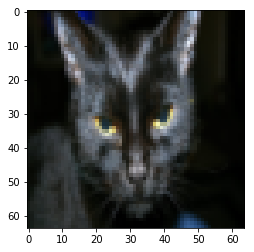

In [3]:
# Here i'm using _orig because this images in not pre-process so i'm going to pre-process this images once after loading. 
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

# As I loaded the image let's getinto one of the image.
# displaying example image
index = 25
plt.imshow(train_set_x_orig[index])
print("Labeles: y = "+str(train_set_y[:,index])+", It's a '"+classes[np.squeeze(train_set_y[:,index])].decode('utf-8')+"' picture.")

In [4]:
# m_train - (no. of training examples)
# m_test - (no. of test examples)
# num_px (height,width of training examples)

# Let's understand the shpae, size, dimesion of the datasets and example

m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]

print("Number of training examples: m_train = "+str(m_train))
print("Number of testing examples: m_train = "+str(m_test))
print("Height/Width of each image: num_px = "+str(num_px))
print("Each image is of size: ("+str(num_px)+", "+str(num_px)+", 3)")
print("train_set_x shape: "+str(train_set_x_orig.shape))
print("train_set_y shape: "+str(train_set_y.shape))
print("test_set_x shape: "+str(test_set_x_orig.shape))
print("test_set_y shape: "+str(test_set_y.shape))


Number of training examples: m_train = 209
Number of testing examples: m_train = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [5]:
#[For easy representation] To feed the data to nueral network we can convert this matrix[n-diemsional numpy array] 
# into single vector [image flattening]
# so let's do it. After flatten the train/test set should look like (height * width * channel, no. of examples)

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print(f"""
train_set_x_flatten shape: {train_set_x_flatten.shape}
train_set_y shape : {train_set_y.shape}
test_set_x_flatten shape : {test_set_x_flatten.shape}
test_set_y shape : {test_set_y.shape}
sanity check after reshaping: {train_set_x_flatten[0:5,0]}
""")



train_set_x_flatten shape: (12288, 209)
train_set_y shape : (1, 209)
test_set_x_flatten shape : (12288, 50)
test_set_y shape : (1, 50)
sanity check after reshaping: [17 31 56 22 33]



_In general to make dataset/features centric and standardize(in-preprocessing) the values we usually subtract the mean from values and then divide by standard deviation_.&nbsp;But in case of pictures dataset, I simply divide each example by 255(maximum value of pixel channel).

In [7]:
# so let's standardize the datasets
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

### Let's Design the learning algorithm.

About logistic regression(explination)

In [9]:
# So basic steps in building algorithm are
# 1) define the model structure
# 2) Initialize the model paramters
# 3) Loop over:
#     calculate loss(forward propagation)
#     calculate gradient(backward propagation)
#     update parameters

# > Lets start with Helper function, Sigmoid
def sigmoid(z):
    """Computing the sigmoid of z
    Arguments:
        x -> A scalar or numpy array of any size
    Return:
        s -> sigmoid(z)
    """
    s = 1 / (1 + np.exp(-z))
    return s

In [17]:
# Test our sigmoid function
print("sigmoid(0) = "+str(sigmoid(0)))
print("sigmoid(9.2) = "+str(sigmoid(9.2)))
print("sigmoid(-1) = "+str(sigmoid(-1)))

sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922
sigmoid(-1) = 0.2689414213699951


In [18]:
# In case of any regression we initially start with zero that's why we initialize the w, b as to zero

def initialize_with_zeros(dim):
    """This function create a vector of zeros of shape(dim, 1) for w and b initializes to 0
    Arguements:
        dim -> size of the w vector
    Returns:
        w -> initialized vector of shape(dim, 1)
        b -> initialized scalar [b correspond to bias]
    """
    w = np.zeros(shape=(dim,1))
    b = 0
    assert(w.shape == (dim,1))
    assert(isinstance(b, float) or isinstance(b, int))
    return w, b

In [19]:
# Let's test our function
dim = 2
w, b = initialize_with_zeros(dim)
print(f'''
w = {w}
b = {b}
''')

# Note: For our image example w = (height * width * channel, 1)


w = [[0.]
 [0.]]
b = 0



__Forward and backward propagation function__ <br>
&emps; Here I'm going to write propagate function which will take care of forward and backwar moment. When we say forward this actually do forward computation where we multiply the weight vector(w<sup>T</sup>) with training examples(reshape and tranformed sample). In backword computation we compute the cost function (which is total loss of samples) its derivative step's we move backward by computing derivatives and finally we this this value to update the weight and bias.  <br>
***
$A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$<br>
<br>
$J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$<br>
<br>
$\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$

In [20]:
def propagate(w, b, X, Y):
    """Implement the cost function and its gradient for the propagation.
    Arguments:
        w -> weigths, a numpy array of size (num_px * num_px * 3, 1)
        b -> bias, a scalar
        X -> data of size (num_px * num_px * 3, no. of examples)
        Y -> true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)
        
    Return:
        cost -> negative log-likelihood cost for logistic regression
        dw -> gradient of the loss with respect to w, thus same shape as w
        db -> gradient of the loss with respect to b, thus shape as b
    """
    m = X.shape[1]
    
#     forward propagation
    A = sigmoid(np.dot(w.T, X) + b) # compute the activation #This part is also called vectorization
    cost = (-1/m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A))) # compute cost
    
#     backward propagation
    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum( A - Y)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw, "db": db}
    return grads, cost


In [28]:
# Let's test the function 
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print(f"""
dw = {grads["dw"]}
db = {grads["db"]}
cost = {cost}
""")


dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205



In [29]:
# Now let's work on optimization function
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    """This function optimizes w and b by running a gradient descent algorithm
    Arguments:
        w -> weigths, a numpy array of size (num_px * num_px * 3, 1)
        b -> bias, a scalar
        X -> data of size (num_px * num_px * 3, no. of examples)
        Y -> true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)
        num_iterations -> number of iteration of optimization loop
        learning_rate -> learning rate of the gradient descent update rule
        print_cost -> True to print loss every 100 steps
        
    Returns:
        params -> dictionary contains weights w and bias b
        grads -> dictionary contains gradients of weights dw and bias db with respect to the cost function
        cost -> list of all the cost computed during optimization, this will be used to plot the learning curve.
    """
    costs = []
    for i in range(num_iterations):
        # calulate the cost and grads
        grads, cost = propagate(w, b, X, Y)
        # retrive derivatives from grads
        dw, db = grads["dw"], grads["db"]
        # update rule
        w = w - learning_rate * dw 
        b = b - learning_rate * db
        
        if i%100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print("Cost after iterartion %i: %f"%(i,cost))
    params = {"w":w,"b":b}
    grads = {"dw":dw, "db":db}
    return params, grads, costs

In [31]:
# Let's test our function
params, grads, costs = optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False)

print(f"""
w = {params["w"]}
b = {params["b"]}
dw = {grads["dw"]}
db = {grads["db"]}
""")


w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828



In [35]:
# Now let's build prediction function
def predict(w, b, X):
    """Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    Arguments:
        w -> weights, a numpy array of size (num_px * num_px * 3, 1)
        b -> bias a scalar
        X -> data of size (num_px * num_px * 3, no. of examples)
        
    Returns:
        Y_prediction -> a numpy array(vector) contains all predictions(0/1) for examples in X
    """
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X) + b)
    for i in range(A.shape[1]):
        # Convert probabilities a[0,i] to actual predictions p[0,i]
        Y_prediction[0, i] = 1 if A[0,i] > 0.5 else 0
    assert(Y_prediction.shape == (1, m))
    return Y_prediction

In [36]:
# Let's test our function
print("Prediction = " + str(predict(w, b, X)))

Prediction = [[1. 1.]]


In [51]:
# Let's merge all to get single model function

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function we implemented previously
    Arguments:
        X_train -> training set, numpy array of shape(num_px * num_px * 3, m_train)
        Y_train -> training labels, numpy array(vector) of shape(1, m_train)
        X_test -> test set, numpy array of shape(num_px * num_px * 3, m_test)
        Y_test -> test labels, numpy array(vector) of shape(1, m_test)
        num_iterations -> hyperparameter, no. of iterations to optimize the parameters
        learning_rate -> hyperparameters, learning rate used in the update rule of optimize()
        print_cost -> set to true, to print cost every 100 iterations
    Returns:
        d -> dictionary containing information about the model
    """
    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])
    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # retrive parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    # print train/test Errors
    print(f"""
    train accuracy : {100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100}%
    test accuracy : {100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100}%
    """)
    
    d = {
        "costs" : costs,
        "Y_prediction_test" : Y_prediction_test,
        "Y_prediction_train": Y_prediction_train,
        "w" : w,
        "b" : b,
        "learning_rate" : learning_rate,
        "num_iterations" : num_iterations
    }
    return d


In [52]:
# Let's test the function
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iterartion 0: 0.693147
Cost after iterartion 100: 0.584508
Cost after iterartion 200: 0.466949
Cost after iterartion 300: 0.376007
Cost after iterartion 400: 0.331463
Cost after iterartion 500: 0.303273
Cost after iterartion 600: 0.279880
Cost after iterartion 700: 0.260042
Cost after iterartion 800: 0.242941
Cost after iterartion 900: 0.228004
Cost after iterartion 1000: 0.214820
Cost after iterartion 1100: 0.203078
Cost after iterartion 1200: 0.192544
Cost after iterartion 1300: 0.183033
Cost after iterartion 1400: 0.174399
Cost after iterartion 1500: 0.166521
Cost after iterartion 1600: 0.159305
Cost after iterartion 1700: 0.152667
Cost after iterartion 1800: 0.146542
Cost after iterartion 1900: 0.140872

    train accuracy : 99.04306220095694%
    test accuracy : 70.0%
    



y = 0, you predicted that it is a cat picture 



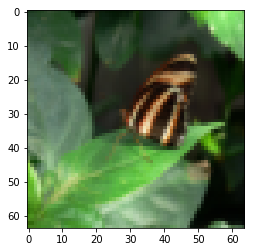

In [75]:
# Let's see the prediction 
# prediction - which wrongly classify the example

index = 5
plt.imshow(test_set_x[:,index].reshape((64, 64, 3)))
print(f"""
y = {test_set_y[0,index]}, you predicted that it is a {classes[int(d['Y_prediction_test'][0,index])].decode('utf-8')} picture 
""")

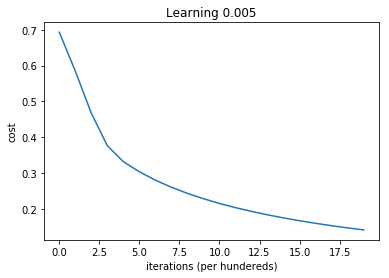

In [78]:
# Let's understand other captured parameters as well
# learning curve
costs_plt = np.squeeze(d['costs'])
plt.plot(costs_plt)
plt.ylabel('cost')
plt.xlabel('iterations (per hundereds)')
plt.title(f'Learning {d["learning_rate"]}')
plt.show()

__Interpretation:__<br>&emsp;*You can see the cost decreasing. It shows that the parameters are being learned. However, you see that you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting.*

learning rate is: 0.01

    train accuracy : 99.52153110047847%
    test accuracy : 68.0%
    
----***----
learning rate is: 0.001

    train accuracy : 88.99521531100478%
    test accuracy : 64.0%
    
----***----
learning rate is: 0.0001

    train accuracy : 68.42105263157895%
    test accuracy : 36.0%
    
----***----
learning rate is: 0.007

    train accuracy : 99.04306220095694%
    test accuracy : 70.0%
    
----***----


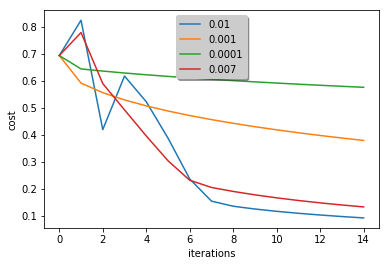

In [82]:
# Let's try with different hyperparameters

learning_rates = [0.01, 0.001, 0.0001, 0.007]
models = {}
for i in learning_rates:
    print(f"learning rate is: {i}")
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print('----***----')
for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label=str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.80')
plt.show()
    

 * Different learning rates give different costs and predictions
 * If learning rate is too high(0.01), then cost may oscillate up and down. It may even diverge.
 * A lower cost doesn't mean a better model. We have to check if there is possibly overfitting. It happens when the training accuracy is lot higher than the test accuracy.
 * In deeplearning
         - Choose the learning rate that better minimizes the cost function
         - If model overfits, Use other techniques to reduce overfitting.
 

y = 0.0, your algorithm predicts a "non-cat" picture.


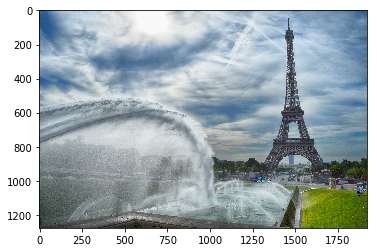

In [101]:
# Testing our classifier with new image and see out it performs
my_image = '../datasets/not_cat_image.jpg'
image = np.array(plt.imread(my_image))
my_image = np.array(Image.fromarray(image).resize((64,64))).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")


y = 1.0, your algorithm predicts a "cat" picture.


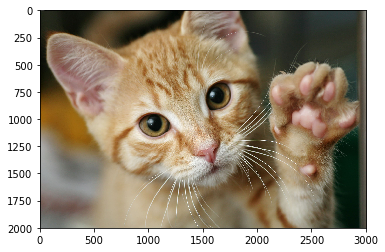

In [102]:
# Testing our classifier with new image and see out it performs
my_image = '../datasets/cat_image.jpeg'
image = np.array(plt.imread(my_image))
my_image = np.array(Image.fromarray(image).resize((64,64))).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")